## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  49.89 s
2: Total numb steps is  608
The file 'm-3-5.msh' exists, start creat now:
DOLFINx version: 0.8.0
Simulation environment setup complete.

[60. 60. 60. ... 60. 60. 60.]
[60. 60. 60. ... 60. 60. 60.]
0,before rotation, x_co is 214.0
0,after rotation, before transformation, x_co is -135.1829412700784
Deformation is  [0. 0. 0. ... 0. 0. 0.]
0,after transformation, x_co is -134.9246796158838
1: Progress: 0.1%. Use time: 19 s. Start: 2024-11-05 14:39:56.                  [60.05067858 60.03205031 59.99137795 ... 60.00002049 60.00006203
 60.00007649]
[60.05067858 60.03205031 59.99137795 ... 60.00002049 60.00006203
 60.00007649]
1,before rotation, x_co is -134.9246796158838
1,after rotation, before transformation, x_co is -24.470489950090553
Deformation is  [0. 0. 0. ... 0. 0. 0.]
1,after transformation, x_co is -24.470489950090517
1: Progress: 0.2%. Use time: 31 s. Start: 2024-11-05 14:39:56.        

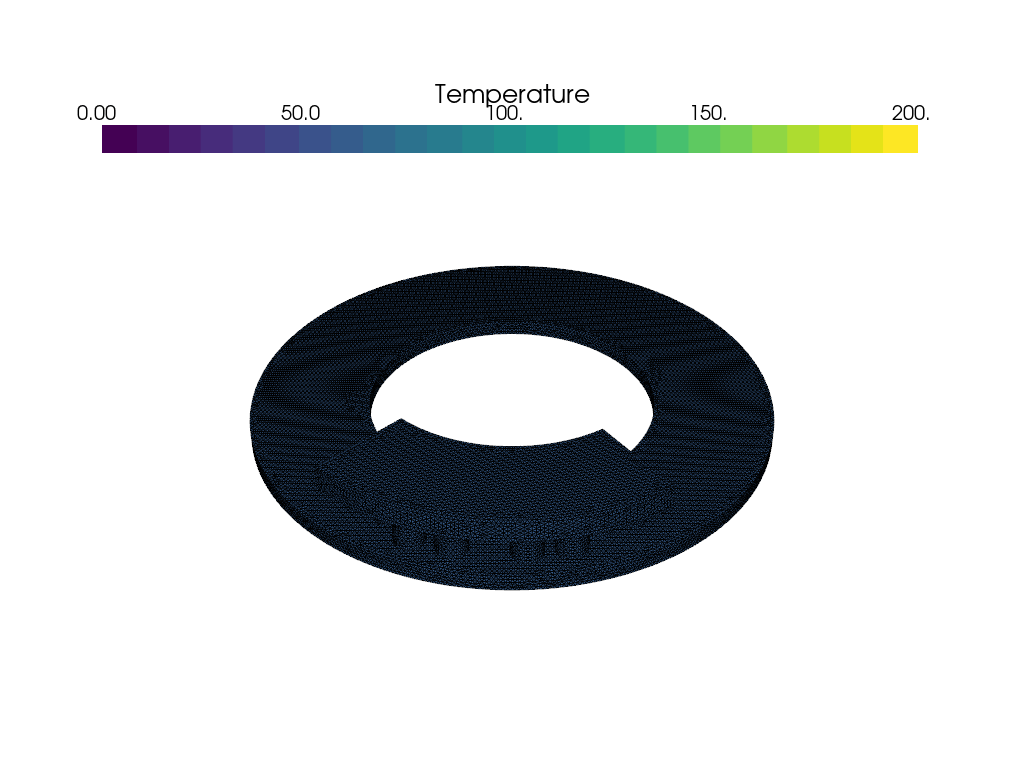

In [1]:
from disc_f1 import *

# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 5
c_contact          = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 224
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z4,z_all  = 20,33,30,83,8
pad_v_tag          = 32
# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle_ini, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_markers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)

V, T_init, u_n         = initial_u_n(domain, Ti)

fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup( domain, V, mesh_name1, num_steps, \
                         angular_r, mesh_name2, c_contact, z_all, Tm, S_rub_circle_ini)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init, domain, rho, c, b_con,\
                          radiation, h, k, xdmf, dt, ds, u_n, Tm,g,bc);
solver_setup_solve(problem,u)

## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
num_steps= int(num_steps/10/6)


################################################################
def solve_heat(Ti, u_initial, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle, fdim,\
               rho, c, v, radiation, k, h, f, Tm, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone,  ):
  
    T_array = [(0, [Ti for _ in range(len(u_initial.x.array))])]
    total_degree = 0
    t = 0
    fraction_c = []
    for i in range(num_steps):
         t += dt[i]

        ##################################3
        # u_do is the deformation without any contact constrain, no plenaly force, mm.
         if i == 0: 
            u.x.array[:] = np.full(len(u_initial.x.array), 60) 
            u_old = u
         else:
            u_old = u_old1

         if i ==0:
            x_co_new = x_co
            y_co_new = y_co
         else:
            pass

        
         print(u_old.x.array)
         print(u.x.array)

         print(f"{i :},before rotation, x_co is {x_co_new[0]}")
         x_co_new, y_co_new = rub_rotation(x_co_new, y_co_new, angular_r)  # update the location
         print(f"{i :},after rotation, before transformation, x_co is {x_co_new[0]}")
         total_degree += angular_r  # Incrementing degree in each step    

         if i == 0:
             u_d0, Vu, aM, LM, bcu, u_, domain_pad = T_S_deformation_solve (mesh_name1, u_initial, mesh_brake, pad_v_tag, z4, u_old)
         else:
             u_d0, Vu, aM, LM, bcu, u_, domain_pad = T_S_deformation_solve (mesh_name1, u, mesh_brake, pad_v_tag, z4, u_old)
    
    
         print("Deformation is ", u_d0.x.array)
         # u_d1 is the new deformation with contact force, mm.
         u_d1 = penalty_method_contact(z1, Vu, u_d0, aM, LM, u_, bcu )

        
         ###### test1
         #scale_factor = 10000
         #plot_s_pad = plot_S_pad(Vu, u_d1, scale_factor)
         #plot_s_pad.show()
         ###### test1
        
         # calculate new contact coordinates and contact incicies of u_d, deformation.
         deformed_co, new_c   = get_new_contact_nodes(x_co_zone, domain_pad, u_d1, Vu, z1, x_co, y_co )

         # find new contact coordinates and rub radius.
         x_co_new1, y_co_new1, r_rub_new, S_total_new, S_rub_circle_new = get_r_xco_yco (deformed_co, new_c )
         x_co_new, y_co_new = rub_rotation(x_co_new1, y_co_new1, angular_r*(i+1))
        
         print(f"{i :},after transformation, x_co is {x_co_new[0]}")
         #####
         #print(x_co, y_co) 
        
         S_rub_circle = S_rub_circle_new
         fraction_c.append(  S_total_new/ 200 )
         #####################################

         #x_co, y_co = rub_rotation(x_co_new, y_co_new, angular_r)  # update the location
         #total_degree += angular_r  # Incrementing degree in each step
        
         # Construct the message     
         end_time = time.time()
         elapsed_time = end_time - start_time
         elapsed_time1 = round(elapsed_time, 0)
         formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
         if elapsed_time1 >= 60:
            min = elapsed_time1 / 60
            hours = min / 60
            progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: {round(hours)} hours {round(min)} min. Start: {formatted_start_time }."
         else:
            progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: {round(elapsed_time1)} s. Start: {formatted_start_time }."
         sys.stdout.write(f"\r{progress_message.ljust(80)}")  # 80 spaces to ensure full clearing
         sys.stdout.flush()
        
         #####################################
         co_ind, fa_mar, so_ind   = target_facets(domain, x_co_new, y_co_new, S_rub_circle )
         facet_tag                = meshtags( domain, fdim, co_ind[ so_ind], fa_mar[ so_ind] )
         ds                       = Measure("ds", domain=domain, subdomain_data=facet_tag)
         #print(co_ind)     

         F = ((rho * c) / dt[i] * inner(u, v) * dx
             + k * inner(grad(u), grad(v)) * dx
             + h * inner(u, v) * ds(b_con)
             + radiation * inner(u**4, v) * ds(b_con)
             - ( inner(f, v) * dx
                 + (rho * c) / dt[i] * inner(u_n, v) * dx
                 + h * Tm * v * ds(b_con)
                 + radiation * (Tm**4) * v * ds(b_con)) )

         for j in list(range(1, 19)):
             #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
             F += ( - inner(g[i], v) * ds(10 * j) 
                    - h * inner( u, v) * ds(10 * j)  
                    - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) )    

         u_old1 = u
             
         problem = NonlinearProblem(F, u, bcs=[bc])
         ## 7: Using petsc4py to create a linear solver
         solver_setup_solve(problem, u)
         u.x.scatter_forward()
     
 
        # Update solution at previous time step (u_n)
         u_n.x.array[:] = u.x.array
         T_array.append((t, u.x.array.copy()))
         # Write solution to file
         xdmf.write_function(u, t)
         # Update plot
         #warped = grid.warp_by_scalar("uh", factor=0)
         plotter.update_coordinates(warped.points.copy(), render=False)
         plotter.update_scalars(u.x.array, render=False)
         plotter.write_frame()

    plotter.close()
    xdmf.close()
    print()
    return(T_array, fraction_c, Vu)
 
###################################################################
x_co_zone   = 0.01

T_array,fraction_c, Vu = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle_ini, fdim,\
               rho, c, v, radiation, k, h, f, Tm, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone, )
####################################################################

csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
save_t_T(csv_name, T_array) # got the Temperature data

from IPython.display import display, Image
display(Image(gif_name))

In [2]:
print(type(u.x.array))

<class 'numpy.ndarray'>


In [3]:
array_tem = np.full(len(u.x.array), 60) 
print(array_tem)

[60 60 60 ... 60 60 60]


In [4]:
c = [60,60,60,60]
print(type(c))

d = np.array( [60,  60, 60] )
print(d)

print(type(u_n.x.array))

<class 'list'>
[60 60 60]
<class 'numpy.ndarray'>


[0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663, 0.9760291347951663]


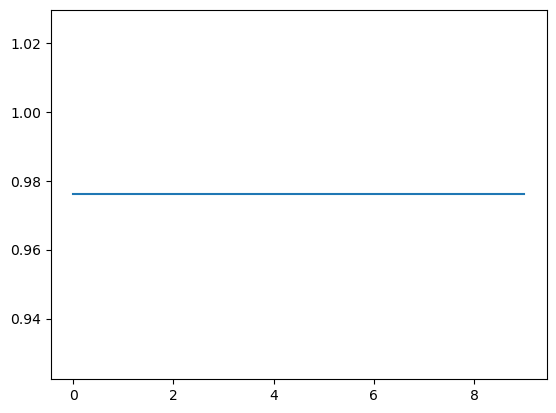

In [5]:
print((fraction_c))
plt.plot(fraction_c)

In [6]:
scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()

NameError: name 'u_d' is not defined

# 2: New brake pad points, add boundary for rubbing elements

u_d, Vu, aM, LM, bcu, u_,  domain_pad   = T_S_deformation_solve (mesh_name1, u_n, mesh_brake, pad_v_tag, z4, u_old )
u_d = penalty_method_contact(z1, Vu, u_d, aM, LM, u_, bcu ) 
x_co_zone   = 0.002
deformed_co, new_c = get_new_contact_nodes(x_co_zone, domain_pad, u_d,  Vu, z1, x_co, y_co )
x_co_new, y_co_new, r_rub_new, S_total_new,S_rub_circle_new = get_r_xco_yco (deformed_co, new_c )
fraction_c = S_total_new/ 200


print('Total contact surface is: ', round(S_total_new, 2), " mm")
print(f"Contact friction is {fraction_c:.2f}")


scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()

vtk = io.VTKFile(domain_pad.comm, "pad_deformation", "w")
vtk.write_function(u_d)
vtk.close()